In [1]:
import os
import torch
import argparse
import numpy as np
import pandas as pd
from util import * 
from model import *
from pandas import DataFrame
import sklearn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from DNA_Bert_finetuning_average_L2_for_sequence_embedding_analyze_util import *

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/home/lijiahao/anaconda3/envs/tensorflow_pytorch_python/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--epoches',              type=int,  default=300,  help='')
parser.add_argument('--batch_size',           type=int,  default=16,  help='')
parser.add_argument('--max_length',           type=int,  default=200, help='')
parser.add_argument('--learning_rate',        type=float, default=1e-4, help="")
parser.add_argument('--model_path',           type=str,  default="../3-new-12w-0", help='')

parser.add_argument('--ind_filename',  type=str,  default="../dataset/enhancer_3-mer_DNABERT_ind.txt", help='')
parser.add_argument('--tra_filename',  type=str,  default="../dataset/enhancer_3-mer_DNABERT_tra.txt", help='')

args = parser.parse_args(args=[]) 

mer = 3
args.model_path = "../{}-new-12w-0".format(mer)

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
def calculation_cos(token_embeddings):
    embedding_cos = []
    for i in range(len(token_embeddings)):
        target_embedding = token_embeddings[i]
        cos_item = []
        for j in range(len(token_embeddings)):
            query_embedding = token_embeddings[j]
            
# the different of kmer between enhancer and non enhancer

enhancer_sequence_filename = "sequence/enhancer_sequence_instance_1484.txt"
non_enhancer_sequence_filename = "sequence/non_enhancer_sequence_instance_1484.txt"

enhancer_sequence_token_embeddings, enhancer_token_keys = get_embedding_for_sequence_token(args, enhancer_sequence_filename, mer)
"""
enhancer_sequence_token_embeddings.shape: (number_batch-size, batch_size, max_length, 768)
# print("enhancer_sequence_token_embeddings: {}; enhancer_token_keys: {}".format(enhancer_sequence_token_embeddings.shape, enhancer_token_keys.shape))
"""

non_enhancer_sequence_token_embeddings, non_enhancer_token_keys = get_embedding_for_sequence_token(args, non_enhancer_sequence_filename, mer)

Some weights of the model checkpoint at ../3-new-12w-0 were not used when initializing C_Bert_2FC_average_embedding: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing C_Bert_2FC_average_embedding from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing C_Bert_2FC_average_embedding from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of C_Bert_2FC_average_embedding were not initialized from the model checkpoint at ../3-new-12w-0 and are newly initi

In [4]:
# record the scatter token embedding
all_tokens = []
token_scatter = np.load("sequence/scatter_token_embedding.npy", allow_pickle=True)
scatter_token_embedding_dict = {}
for item in token_scatter:
    if item[0] not in scatter_token_embedding_dict.keys():
        scatter_token_embedding_dict[item[0]] = []
        all_tokens.append(item[0])
    scatter_token_embedding_dict[item[0]].append(item[1])

# enhancer token embedding
enhancer_token_embedding_dict = {}
for index in range(len(enhancer_sequence_token_embeddings)):
    token_embeddings = enhancer_sequence_token_embeddings[index][0]
    token_keys = enhancer_token_keys[index]
 
    for i in range(len(token_keys)):
        if token_keys[i] not in enhancer_token_embedding_dict.keys():
            enhancer_token_embedding_dict[token_keys[i]] = []
        enhancer_token_embedding_dict[token_keys[i]].append(token_embeddings[i])
    
# non-enhancer token embedding
non_enhancer_token_embedding_dict = {}
for index in range(len(non_enhancer_sequence_token_embeddings)):
    token_embeddings = non_enhancer_sequence_token_embeddings[index][0]
    token_keys = non_enhancer_token_keys[index]
   
    for i in range(len(token_keys)):
        if token_keys[i] not in non_enhancer_token_embedding_dict.keys():
            non_enhancer_token_embedding_dict[token_keys[i]] = []
        non_enhancer_token_embedding_dict[token_keys[i]].append(token_embeddings[i])

# token = "CCT" # good behave 
# token = "TCC" # good behave 

# for count_token, token in enumerate(all_tokens):

#     token_embeddings = []
#     token_length_scatter = len(scatter_token_embedding_dict[token])
#     token_length_enhancer = len(enhancer_token_embedding_dict[token])
#     token_length_non_enhancer = len(non_enhancer_token_embedding_dict[token])
#     print("length of scatter:{}, length of token in enhancer: {}, length of token in non-enhancer: {}".format(token_length_scatter, token_length_enhancer, token_length_non_enhancer))
#     token_embeddings += scatter_token_embedding_dict[token]
#     token_embeddings += enhancer_token_embedding_dict[token]
#     token_embeddings += non_enhancer_token_embedding_dict[token]

#     token_embedding_tsne_proj = tsne(token_embeddings)

#     scatter_token_embedding_proj = token_embedding_tsne_proj[0:token_length_scatter]
#     enhancer_token_embedding_proj = token_embedding_tsne_proj[token_length_scatter:token_length_scatter+token_length_enhancer]
#     non_enhancer_token_embedding_proj = token_embedding_tsne_proj[token_length_scatter+token_length_enhancer:token_length_scatter+token_length_enhancer+token_length_non_enhancer]

#     plt.figure(figsize=(10, 10))
#     ax = plt.subplot(1,1,1)
#     # ax.scatter(scatter_token_embedding_proj[:,0], scatter_token_embedding_proj[:,1], marker="*", c="red", s=250, label="Scatter Token")
#     ax.scatter(enhancer_token_embedding_proj[:, 0], enhancer_token_embedding_proj[:, 1], marker="o", c="green", s=50, label="{} of enhancer".format(token))
#     ax.scatter(non_enhancer_token_embedding_proj[:, 0], non_enhancer_token_embedding_proj[:, 1], marker="o", c="orange", s=50, label="{} of non-enhancer".format(token))
#     ax.scatter(scatter_token_embedding_proj[:,0], scatter_token_embedding_proj[:,1], marker="*", c="red", s=250, label="Scatter Token-{}".format(token))
    
#     plt.xticks([])
#     plt.yticks([])
#     plt.title("the t-SNE projection of token-{}_1484".format(token))
#     plt.rcParams.update({'font.size': 15})
#     plt.legend(loc="upper left")
#     plt.savefig("image/Token-{}_t-sne_projection_1484.svg".format(token), bbox_inches='tight')
#     plt.show()
token = "CCT"
token_embeddings = []
token_length_scatter = len(scatter_token_embedding_dict[token])
token_length_enhancer = len(enhancer_token_embedding_dict[token])
token_length_non_enhancer = len(non_enhancer_token_embedding_dict[token])
print("length of scatter:{}, length of token in enhancer: {}, length of token in non-enhancer: {}".format(token_length_scatter, token_length_enhancer, token_length_non_enhancer))
token_embeddings += scatter_token_embedding_dict[token]
token_embeddings += enhancer_token_embedding_dict[token]
token_embeddings += non_enhancer_token_embedding_dict[token]

token_embedding_tsne_proj = tsne(token_embeddings)

scatter_token_embedding_proj = token_embedding_tsne_proj[0:token_length_scatter]
enhancer_token_embedding_proj = token_embedding_tsne_proj[token_length_scatter:token_length_scatter+token_length_enhancer]
non_enhancer_token_embedding_proj = token_embedding_tsne_proj[token_length_scatter+token_length_enhancer:token_length_scatter+token_length_enhancer+token_length_non_enhancer]


length of scatter:1, length of token in enhancer: 7075, length of token in non-enhancer: 4457


/home/lijiahao/anaconda3/envs/tensorflow_pytorch_python/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/lijiahao/anaconda3/envs/tensorflow_pytorch_python/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


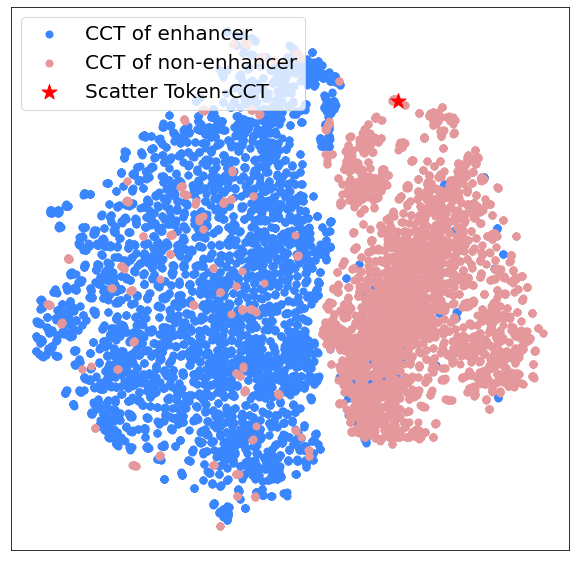

In [5]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
# ax.scatter(scatter_token_embedding_proj[:,0], scatter_token_embedding_proj[:,1], marker="*", c="red", s=250, label="Scatter Token")
ax.scatter(enhancer_token_embedding_proj[:, 0], enhancer_token_embedding_proj[:, 1], marker="o", c="#3A86FF", s=50, label="{} of enhancer".format(token))
ax.scatter(non_enhancer_token_embedding_proj[:, 0], non_enhancer_token_embedding_proj[:, 1], marker="o", c="#E5989B", s=50, label="{} of non-enhancer".format(token))
ax.scatter(scatter_token_embedding_proj[:,0], scatter_token_embedding_proj[:,1], marker="*", c="red", s=250, label="Scatter Token-{}".format(token))
    
plt.xticks([])
plt.yticks([])
# plt.title("the t-SNE projection of token-{}_1484".format(token))
plt.rcParams.update({'font.size': 20})
plt.legend(loc="upper left")
plt.savefig("image/Token-{}_t-sne_projection_1484.svg".format(token), bbox_inches='tight')
plt.show()

/home/lijiahao/anaconda3/envs/tensorflow_pytorch_python/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/lijiahao/anaconda3/envs/tensorflow_pytorch_python/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


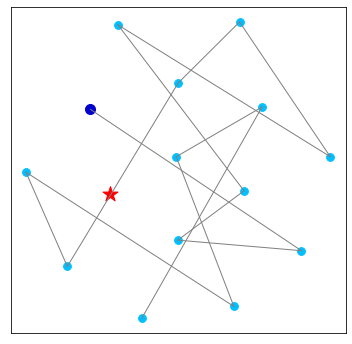

Position of Token-CCT in the original sequence [2, 15, 31, 51, 82, 93, 96, 99, 116, 135, 156, 160, 173, 183]
Position interval of Token-CCT in the original sequence [13, 16, 20, 31, 11, 3, 3, 17, 19, 21, 4, 13, 10]
 1.0000; -0.4783; -0.4768; -0.5018; -0.4997; -0.3750; -0.3935; -0.3926; -0.3654; -0.3801; -0.3622; -0.3610; -0.3533; -0.4097; -0.4307; 
-0.4783;  1.0000;  0.9837;  0.9742;  0.9869;  0.9567;  0.9593;  0.9564;  0.9444;  0.9624;  0.9458;  0.9539;  0.9464;  0.9740;  0.9800; 
-0.4768;  0.9837;  1.0000;  0.9836;  0.9846;  0.9592;  0.9554;  0.9586;  0.9390;  0.9546;  0.9424;  0.9438;  0.9377;  0.9713;  0.9681; 
-0.5018;  0.9742;  0.9836;  1.0000;  0.9794;  0.9423;  0.9327;  0.9396;  0.9168;  0.9341;  0.9180;  0.9261;  0.9157;  0.9557;  0.9482; 
-0.4997;  0.9869;  0.9846;  0.9794;  1.0000;  0.9474;  0.9595;  0.9585;  0.9397;  0.9577;  0.9439;  0.9477;  0.9441;  0.9655;  0.9732; 
-0.3750;  0.9567;  0.9592;  0.9423;  0.9474;  1.0000;  0.9607;  0.9696;  0.9617;  0.9646;  0.9695;  0.961

In [6]:
# # for scatter token embedding

# args.tra_filename = "./sequence/scatter_token.txt"
# tra_dataloader = getData(args, split=False, validation=False, shuffle=True)
# token_embeddings, token = get_embedding_for_scatter_token(args, tra_dataloader, mer)

# scatter_token_embedding = []
# for item in zip(token, token_embeddings):
#     scatter_token_embedding.append(item)

# np.save("sequence/scatter_token_embedding", scatter_token_embedding)
# print("({}, {})".format(len(token_embeddings), len(token_embeddings[0])))
# print(token)

# 从上面的例子中，选择一条enhancer，分析在该序列当中，token与位置之间的差异
# 单个序列里面，token的embedding可视化分析
index = 806

token_embeddings = enhancer_sequence_token_embeddings[index][0]
token_keys = enhancer_token_keys[index]
token_index = []
token_index_diff = []

# record the single token embedding
token_embedding_single_dict = {}    
for i in range(len(token_keys)):
    if token_keys[i] not in token_embedding_single_dict.keys():
        token_embedding_single_dict[token_keys[i]] = []
    token_embedding_single_dict[token_keys[i]].append(token_embeddings[i])

# record the index of Token in the raw sequence
for index, item in enumerate(token_keys):
    if item == token:
        token_index.append(index)

for index in range(1, len(token_index)):
    token_index_diff.append(token_index[index]-token_index[index-1])


token_embedding = []
token_embedding += scatter_token_embedding_dict[token]
token_embedding += token_embedding_single_dict[token]

token_length_scatter = len(scatter_token_embedding_dict[token])
token_embedding_single = len(token_embedding_single_dict[token])

token_embeddings_tsne_proj = tsne(token_embedding)

plt_scatter(token_embeddings_tsne_proj, "Token-{}-Scatter Token vs Contextual Token of Single".format(token))
print("Position of Token-{} in the original sequence".format(token), token_index)
print("Position interval of Token-{} in the original sequence".format(token), token_index_diff)

cos_token_embedding = cosine_similarity(token_embedding)
for i in range(len(cos_token_embedding)):
    for j in range(len(cos_token_embedding[0])):
        print("{: .4f}".format(cos_token_embedding[i,j]), end="; ")
    print()
    

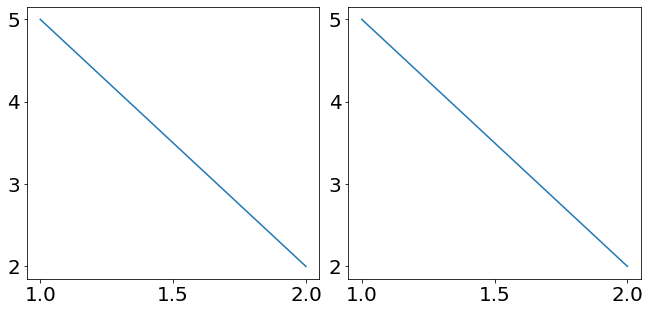

In [7]:
plt.figure(figsize=(11, 5))

plt.subplot(1,2,1)
plt.plot([1,2], [5,2])

plt.subplot(1,2,2)
plt.plot([1,2], [5,2])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
plt.show()


In [8]:
a = {}

if "a" not in a.keys():
    print("asd")

else:
    print("asdfasf")


asd


In [9]:
# enhancer_sequence_filename = "../dataset/enhancer_3-mer_DNABERT_strong_tra.txt"
# enhancer_sequence = "sequence/enhancer_sequence_instance.txt"
# enhancer_sequence_file = open(enhancer_sequence_filename)
# enhancer_sequence_write = open(enhancer_sequence, "w")
# enhancer_sequences = enhancer_sequence_file.readlines()
# for enhancer in enhancer_sequences:
#     enhancer = enhancer.split("\n")[0]
#     enhancer = enhancer[0:-1]
#     enhancer += "\t1\n"
#     enhancer_sequence_write.write(enhancer)

# enhancer_sequence_file.flush()
# enhancer_sequence_file.close()


In [10]:
# non_enhancer_sequence_filename = "../dataset/enhancer_3-mer_DNABERT_tra.txt"
# non_enhancer_sequence = "sequence/non_enhancer_sequence_instance.txt"
# non_enhancer_sequence_file = open(non_enhancer_sequence_filename)
# non_enhancer_sequence_write = open(non_enhancer_sequence, "w")
# non_enhancer_sequences = non_enhancer_sequence_file.readlines()

# for index, sequence in enumerate(non_enhancer_sequences):
#     if index >= 742:
#         break
#     non_enhancer_sequence_write.write(sequence)
    
# non_enhancer_sequence_write.flush()
# non_enhancer_sequence_write.close()

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
a = np.array([[1.0, 2.0, 3.0], [1.0, 3.0, 2.0]])
b = np.array([[2.0, 1.0, 1.0], [1.0, 1.0, 1.0]])
print(a)
print(b)
c = cosine_similarity(a, b)
print(c)
print(c[1][1])

[[1. 2. 3.]
 [1. 3. 2.]]
[[2. 1. 1.]
 [1. 1. 1.]]
[[0.76376262 0.9258201 ]
 [0.76376262 0.9258201 ]]
0.9258200997725516
